# Test: free fall time in streamline model in comparison with the theoretical streamline model

In [2]:
%matplotlib inline
import sys
sys.path.append('../')
import numpy as np
import astropy.units as u
import velocity_tools.stream_lines as SL
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.io import fits
from astropy.constants import G
from NOEMAsetup import *
from astropy.coordinates import SkyCoord, FK5


In [2]:
# Just if you are curious, this is how different the timescales look theoretically when considering continuous infalling motion
r0 = 1000 * u.au
rfin = np.arange(0, r0.value+10, 10) * u.au
print(rfin)
t_ff_acc = t_freefall(r0, 1*u.Msun) - t_freefall_acc(rfin, r0)
print(t_freefall_acc(0., r0))
print(t_freefall(r0, 1*u.Msun))
plt.plot(rfin, t_ff_acc, 'k',label=r'Considering previous trajectory ($v_r\neq0$)')
plt.plot(rfin, t_freefall(rfin, 1*u.Msun),'r', label=r'$v_r=0$ in each point')
plt.xlabel('Distance (au)')
plt.ylabel('Free-fall time (yr)')
plt.legend(frameon=False)


[   0.   10.   20.   30.   40.   50.   60.   70.   80.   90.  100.  110.
  120.  130.  140.  150.  160.  170.  180.  190.  200.  210.  220.  230.
  240.  250.  260.  270.  280.  290.  300.  310.  320.  330.  340.  350.
  360.  370.  380.  390.  400.  410.  420.  430.  440.  450.  460.  470.
  480.  490.  500.  510.  520.  530.  540.  550.  560.  570.  580.  590.
  600.  610.  620.  630.  640.  650.  660.  670.  680.  690.  700.  710.
  720.  730.  740.  750.  760.  770.  780.  790.  800.  810.  820.  830.
  840.  850.  860.  870.  880.  890.  900.  910.  920.  930.  940.  950.
  960.  970.  980.  990. 1000.] AU


TypeError: t_freefall_acc() missing 1 required positional argument: 'r0'

First, we run a streamline model with little rotation for testing

In [3]:
# model parameters
M_s = 1.71*u.Msun # was 2.9
M_env = 0.39*u.Msun # upper limit
M_disk = 0.58*u.Msun
Mstar = (M_s+M_env+M_disk)
# Mstar = 1 * u.Msun

# Disk inclination system
inc = 0. * u.deg
PA_ang = 0. *u.deg

theta0 = 61.5 * u.deg  # rotate clockwise
phi0 = 28. * u.deg  # rotate the plane
v_r0 = 1.25 * u.km/u.s
r0 = 3300*u.au

omega0 = 4.53e-13 / u.s

# what happens if we incline it? seems that nothing, luckily
# inc = 30. * u.deg
# PA_ang = 10. *u.deg

# theta0 = 70 * u.deg  # rotate clockwise
# phi0 = 10. * u.deg  # rotate the plane
# v_r0 = 0. * u.km/u.s
# r0 = 1000 *u.au

# omega0 = 1e-14 / u.s

Then, we run our model.

From the model we need:
- the distance from the protostar to all points along the streamer 
- the magnitude of the velocity at each point
- The size of each segment along the streamer
- The time required to travel each segment
- The time to get from the protostar to that point along the streamer (cumulative sum from each segment)
- The theoretical free fall timescale in each point

In [4]:
(x1, y1, z1), (vx1, vy1, vz1) = SL.xyz_stream(mass=Mstar, r0=r0, theta0=theta0, phi0=phi0, omega=omega0, v_r0=v_r0, inc=inc, pa=PA_ang, deltar=10*u.au)

dist_streamer = np.sqrt(x1**2 + y1**2 + z1**2) # distance from protostar to point
dist_2d_streamer = np.sqrt(x1**2 + y1**2) # cilyndrical distance from protostar to point

# from the velocity we need to erase the first, and for the segments we need to erase the last
vel_streamer = np.sqrt(vx1**2 + vy1**2 + vz1**2) # total velocity at point x,y,z

# we calculate the size of each segment and the time to travel the streamer
dx1 = np.roll(x1, 1) - x1
dy1 = np.roll(y1, 1) - y1
dz1 = np.roll(z1, 1) - z1
# we need to unroll so that the segments match their velocities
deltas = np.sqrt(dx1**2 + dy1**2 + dz1**2)[2:]
vel_mean = 0.5*(np.roll(vel_streamer, 1) + vel_streamer)[2:]
dist_mean = 0.5*(np.roll(dist_streamer, 1) + dist_streamer)[2:]
dist_2d_mean = 0.5*(np.roll(dist_2d_streamer, 1) + dist_2d_streamer)[2:]
# The last value does not make sense because it is from the last to the first one of the list. 
deltat = (deltas / vel_mean).to(u.yr)
# usually we need to sacrifice the first two points: the first because of the roll and the second because of the initial v=0

# we reverse two times to sum from protostar to start point and return the array to its original order
# t0 = t_freefall(np.amin(dist_streamer.value)*u.au, Mstar) # There must be a time to fall from rmin to the protostar
time_integral_path = np.flip(np.cumsum(np.flip(deltat)))# + t0

rc=229.0772556557776 AU
10.0 AU
tolerance  3.01190379676e-08


In [4]:
time_theory = t_freefall_acc(0 *u.au, dist_mean, r0, mass=Mstar)
print(time_theory)

[4.72071583e+03 4.46956585e+03 4.26647362e+03 4.09177263e+03
 3.93644323e+03 3.79545100e+03 3.66564443e+03 3.54489464e+03
 3.43168301e+03 3.32488087e+03 3.22362204e+03 3.12722441e+03
 3.03513938e+03 2.94691782e+03 2.86218650e+03 2.78063121e+03
 2.70198449e+03 2.62601637e+03 2.55252745e+03 2.48134348e+03
 2.41231112e+03 2.34529460e+03 2.28017304e+03 2.21683826e+03
 2.15519300e+03 2.09514943e+03 2.03662796e+03 1.97955617e+03
 1.92386797e+03 1.86950287e+03 1.81640533e+03 1.76452422e+03
 1.71381239e+03 1.66422622e+03 1.61572529e+03 1.56827211e+03
 1.52183177e+03 1.47637177e+03 1.43186178e+03 1.38827348e+03
 1.34558035e+03 1.30375759e+03 1.26278191e+03 1.22263147e+03
 1.18328577e+03 1.14472552e+03 1.10693260e+03 1.06988993e+03
 1.03358147e+03 9.97992074e+02 9.63107515e+02 9.28914376e+02
 8.95400031e+02 8.62552590e+02 8.30360872e+02 7.98814362e+02
 7.67903184e+02 7.37618073e+02 7.07950350e+02 6.78891902e+02
 6.50435159e+02 6.22573079e+02 5.95299137e+02 5.68607307e+02
 5.42492057e+02 5.169483

We plot the times together. For a model with no rotation and initial radial velocity of zero, there should be no difference 

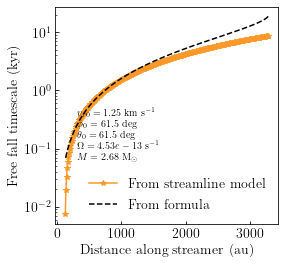

In [6]:
time_theory = t_freefall_acc(0 *u.au, dist_mean, r0, mass=Mstar)
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.plot(dist_mean, time_integral_path/1e3, marker='*', color='#fe9929', label='From streamline model')
ax.plot(dist_mean, time_theory.value/1e3, color='k', linestyle='dashed', label='From formula')
ax.set_xlabel('Distance along streamer (au)')
ax.set_ylabel('Free fall timescale (kyr)')
ax.legend(frameon=False)
ax.annotate(r'$M='+str(Mstar.value)+r'$ M$_{\odot}$', (0.1, 0.3),xycoords='axes fraction', size=10)
ax.annotate(r'$\Omega='+str(omega0.value)+r'$ s$^{-1}$', (0.1, 0.35),xycoords='axes fraction', size=10)
ax.annotate(r'$\theta_0='+str(theta0.value)+r'$ deg', (0.1, 0.4),xycoords='axes fraction', size=10)
ax.annotate(r'$\phi_0='+str(theta0.value)+r'$ deg', (0.1, 0.45),xycoords='axes fraction', size=10)
ax.annotate(r'$v_{r0}='+str(v_r0.value)+r'$ km s$^{-1}$', (0.1, 0.5),xycoords='axes fraction', size=10)
# fig.savefig('test_t_ff_streamline_vs_theory.pdf', dpi=300, bbox_inches='tight')
# ax.set_xlim([0,50])
# ax.set_ylim([0,0.5])
ax.set_yscale('log')

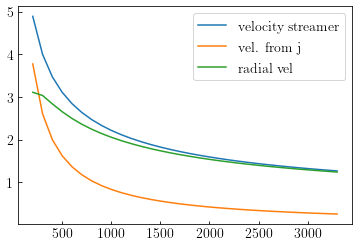

In [12]:
# This is to analyze the velocity components we have
vel_rota = (omega0 * r0**2 / dist_2d_streamer).to(u.km/u.s)
vel_rad = np.sqrt(vel_streamer**2 - vel_rota**2)

plt.plot(dist_streamer, vel_streamer, label='velocity streamer')
plt.plot(dist_streamer, vel_rota, label='vel. from j')
plt.plot(dist_streamer, vel_rad, label='radial vel')
plt.legend()
# plt.ylim([0, 1])

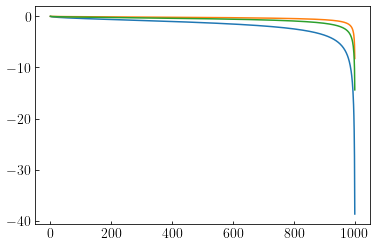

In [32]:
plt.plot(vx1)
plt.plot(vy1)
plt.plot(vz1)

What is below are some tests we did when it was not working

In [34]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.plot(r_test.value, time_theory.value, color='k', linestyle='dashed')

for i in range(len(omega0list)):
    ax.plot(dist_streamer_list[i].value[1:], time_integral_path_list[i].value[1:], label=r'$\Omega_0='+str(omega0list[i].value)+r'$ s-1')
ax.legend(frameon=False)
ax.set_xlabel('3D distance')
ax.set_ylabel('Free fall time')
print(deltat_list[1])
# ax.set_ylim([0,10000])

NameError: name 'r_test' is not defined

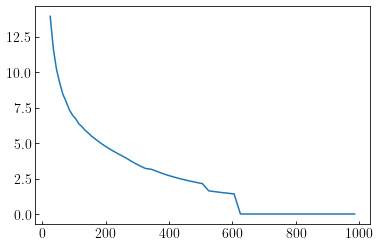

In [41]:
plt.plot(dist_streamer_list[1][1:], vel_streamer_list[1][1:])


In [8]:
print(dist_streamer_list)

[<Quantity [999.5, 998.5, 997.5, 996.5, 995.5, 994.5, 993.5, 992.5, 991.5,
           990.5, 989.5, 988.5, 987.5, 986.5, 985.5, 984.5, 983.5, 982.5,
           981.5, 980.5, 979.5, 978.5, 977.5, 976.5, 975.5, 974.5, 973.5,
           972.5, 971.5, 970.5, 969.5, 968.5, 967.5, 966.5, 965.5, 964.5,
           963.5, 962.5, 961.5, 960.5, 959.5, 958.5, 957.5, 956.5, 955.5,
           954.5, 953.5, 952.5, 951.5, 950.5, 949.5, 948.5, 947.5, 946.5,
           945.5, 944.5, 943.5, 942.5, 941.5, 940.5, 939.5, 938.5, 937.5,
           936.5, 935.5, 934.5, 933.5, 932.5, 931.5, 930.5, 929.5, 928.5,
           927.5, 926.5, 925.5, 924.5, 923.5, 922.5, 921.5, 920.5, 919.5,
           918.5, 917.5, 916.5, 915.5, 914.5, 913.5, 912.5, 911.5, 910.5,
           909.5, 908.5, 907.5, 906.5, 905.5, 904.5, 903.5, 902.5, 901.5,
           900.5, 899.5, 898.5, 897.5, 896.5, 895.5, 894.5, 893.5, 892.5,
           891.5, 890.5, 889.5, 888.5, 887.5, 886.5, 885.5, 884.5, 883.5,
           882.5, 881.5, 880.5, 879.5

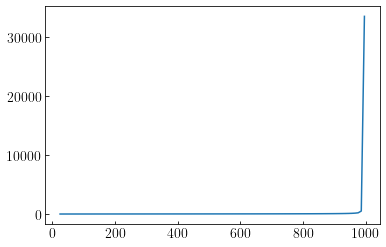

In [42]:
plt.plot(dist_streamer_list[0].value,deltat_list[0].value)

In [3]:
omega_list_JEP = SL.stream_line(dist_streamer_list[0], mass=Mstar, r0=r0, theta0=theta0, omega=omega0list[0], v_r0=v_r0, tol=1e-9)
plt.plot(dist_streamer_list[0], omega_list_JEP)

NameError: name 'dist_streamer_list' is not defined

In [29]:
# model parameters
M_s = 1.71*u.Msun # was 2.9
M_env = 0.39*u.Msun # upper limit
M_disk = 0.58*u.Msun
Mstar = (M_s+M_env+M_disk)
# Disk inclination system
inc = 0. * u.deg
PA_ang = 0. *u.deg

theta0 = 70 * u.deg  # rotate clockwise
phi0 = 0. * u.deg  # rotate the plane
v_r0 = 0.0 * u.km/u.s
r0 = 1000*u.au
omega0 = 1e-14/u.s

small_r_dist = (1000 - 1 * np.arange(30)) * u.au
theta_list_JEP = SL.stream_line(small_r_dist, mass=Mstar, r0=r0, theta0=theta0, omega=omega0, v_r0=v_r0)
vr_JEP, vthera_JEP, vphi_JEP = SL.stream_line_vel(small_r_dist, theta_list_JEP, mass=Mstar, r0=r0, theta0=theta0, omega=omega0, v_r0=v_r0)

rc = SL.r_cent(Mstar,omega=omega0, r0=r0)

rc=0.0009413037917019157 AU


In [19]:
print(theta_list_JEP)

[1.22173048 1.22173048 1.22173048 1.22173048 1.22173048 1.22173048
 1.22173048 1.22173048 1.22173048 1.22173048 1.22173048 1.22173048
 1.22173048 1.22173048 1.22173048 1.22173048 1.22173048 1.22173048
 1.22173048 1.22173048 1.22173048 1.22173048 1.22173048 1.22173048
 1.22173048 1.22173048 1.22173048 1.22173048 1.22173048 1.22173048] rad


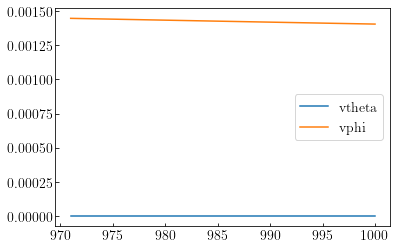

In [30]:
plt.plot(small_r_dist, vthera_JEP, label='vtheta')
plt.plot(small_r_dist, vphi_JEP, label='vphi')
# plt.plot(small_r_dist, vr_JEP, label='vr')
plt.legend()


In [12]:
print('v_r',vr_JEP[0:3])
# print(SL.v_k(rc, Mstar))
# np.cos(theta_list_JEP)/np.cos(70 *u.deg)
mu = (rc / r0).decompose()
nu = (0.*u.km/u.s * np.sqrt(rc / (G * Mstar))).decompose()
epsilon = nu**2 + mu**2 * np.sin(theta0)**2 - 2 * mu
ecc = np.sqrt(1 + epsilon*np.sin(theta0)**2)
orb_ang = np.arccos((1 - mu * np.sin(theta0)**2) / ecc)
cos_ratio = np.cos(theta_list_JEP) / np.cos(theta0)
xi = np.arccos(cos_ratio) + orb_ang.to(u.rad)#.value
print('cosratio', cos_ratio[0:3])
# print(np.arccos(cos_ratio[0:3]))
print('epsilon',epsilon)
print('eccentricity',ecc)
r_to_rc = small_r_dist/rc
v_r_all = -ecc * np.sin(theta0) * np.sin(xi) / r_to_rc /(1 - ecc*np.cos(xi))
v_r_all_pre_factor = -ecc * np.sin(theta0)
print(v_r_all[0:3])
print(v_r_all_pre_factor)
print((np.sin(xi)/ (1 - ecc*np.cos(xi)))[0:3])
print((np.sin(xi))[0:3])
print(np.arccos(cos_ratio), orb_ang)
print(theta_list_JEP)

v_r [-0.1      -0.100001 -0.100002] km / s
cosratio [1. 1. 1.]
epsilon -1.8826068009994947e-06
eccentricity 0.9999991688078347
[-0. -0. -0.]
-0.9396918397207641
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.] rad 0.0 rad
[1.22173048 1.22173048 1.22173048 1.22173048 1.22173048 1.22173048
 1.22173048 1.22173048 1.22173048 1.22173048 1.22173048 1.22173048
 1.22173048 1.22173048 1.22173048 1.22173048 1.22173048 1.22173048
 1.22173048 1.22173048 1.22173048 1.22173048 1.22173048 1.22173048
 1.22173048 1.22173048 1.22173048 1.22173048 1.22173048 1.22173048] rad


In [30]:
# does the model maintain angular momentum?



1.1920929e-07

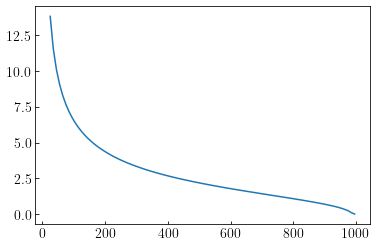

In [47]:
plt.plot(dist_streamer_list[0], vel_streamer_list[0])